In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10, 6))

In [2]:
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

import random
import requests
import re
from copy import copy
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from gensim.models import Word2Vec, FastText

___

## Load and Merge

In [3]:
main_df = pd.read_pickle("data/main_df.pickle")

In [4]:
ingredient_df = pd.read_excel("data/ingredient_table.xlsx")
ingredient_df = ingredient_df[['제품명', '업체명', '주성분', '품목기준코드']].copy()

In [5]:
main_df['itemseq'] = main_df['itemseq'].astype(int)
merged_df = pd.merge(main_df, ingredient_df, left_on='itemseq', right_on='품목기준코드')

In [6]:
merged_df = merged_df[['itemname', 'entpname', 'efcyqesitm', 'usemethodqesitm', 'atpnqesitm',
       'itemseq', '주성분']]

merged_df.rename(columns={'주성분': 'ingredient'}, inplace=True)

In [7]:
merged_df.head()

,itemname,entpname,efcyqesitm,usemethodqesitm,atpnqesitm,itemseq,ingredient
0,활명수,동화약품(주),"<p>이 약은 식욕감퇴(식욕부진), 위부팽만감, 소화불량, 과식, 체함, 구역, 구...","<p>만 15세 이상 및 성인은 1회 1병(75 mL), 만 11세이상~만 15세미...",<p>만 3개월 미만의 젖먹이는 이 약을 복용하지 마십시오.</p>\n\n<p>이 ...,195700020,"건강,육두구,후박,진피,창출,현호색,L-멘톨,육계,정향,아선약,고추틴크"
1,신신티눈고(살리실산반창고)(수출명:SINSINCORNPLASTER),신신제약(주),"<p>이 약은 티눈, 못(굳은살), 사마귀에 사용합니다. </p>\n",<p>이형지로부터 벗겨 이 약제면을 환부(질환 부위)에 대고 테이프로 고정하고 2~...,"<p>이 약에 과민증 환자, 당뇨병, 혈액순환장애 환자는 이 약을 사용하지 마십시오...",195900034,살리실산
2,아네모정,삼진제약(주),"<p>이 약은 위산과다, 속쓰림, 위부불쾌감, 위부팽만감, 체함, 구역, 구토, 위...","<p>성인 1회 2정, 1일 3회 식간(식사와 식사때 사이) 및 취침시에 복용합니다...","<p>투석요법을 받고 있는 환자, 수유부, 만 7세 이하의 어린이, 갈락토오스 불내...",195900043,"탄산마그네슘,탄산수소나트륨,침강탄산칼슘,건조수산화알루미늄겔,스코폴리아엑스10배산"
3,타치온정50밀리그램(글루타티온(환원형)),동아제약(주),"<p>이 약은 약물중독, 자가중독에 사용합니다.</p>","<p>성인은 1회 1~2정(50~100 mg), 1일 1~3회 복용합니다.</p><...",,197100015,글루타티온(환원형)
4,겔포스현탁액(인산알루미늄겔),보령제약(주),"<p>이 약은 위.십이지장 궤양, 위염, 위산과다(속쓰림, 위통, 구역, 구토)의 ...","<p>성인은 1회 1포, 1일 3~4회 식간(식사때와 식사때 사이) 및 취침시 복용...","<p>이 약을 복용하기 전에 신장장애, 변비 환자는 의사 또는 약사와 상의하십시오....",197400207,"콜로이드성인산알루미늄,인산알루미늄겔"


___

## Preprocess the feature

In [8]:
def parser1(x) : 
    parsed = re.sub("\<.{,5}\>|\n|\xa0","",x)
    parsed = parsed.replace("·",',').replace("ㆍ",',')
    
    for _ in range(3) : 
        parsed = parser2(parsed)
        
    return re.sub("이 약은\s*|에 사용합니다.", '', parsed)

def parser2(data) : 
    return re.sub('\([\w\s\,]+\)','', data)

def symptom_parse(x) : 
    parsed = parser1(x)
    parsed = re.sub("([A-Z]{1}[1-9]{,1})\,", r'\g<1> &', parsed)
    parsed = parsed.replace("(",'').replace(")",'')
    return parsed

In [9]:
merged_df['symptom'] = merged_df.efcyqesitm.copy().map(symptom_parse)
merged_df['ingredient'] = merged_df.copy().ingredient.map(parser2).str.replace(" ",'')

prep_caution = list(map(lambda x : re.sub("\<.{,5}\>|\n|\xa0","",x), merged_df.atpnqesitm.copy()))
prep_caution = list(map(lambda x : re.sub('[^가-힣\s0-9]',' ', x), prep_caution))
merged_df['caution'] = prep_caution

prep_df = merged_df[['itemname', 'entpname', 'ingredient', 'symptom', 'caution']].copy()

In [10]:
prep_df['splitted_ingredient'] = prep_df.ingredient.str.split(",")
prep_df['splitted_symptom'] = prep_df.symptom.str.split(",").map(lambda x : list(map(lambda i : i.strip(), x)))
prep_df['tokenized_caution'] = list(map(lambda x : word_tokenize(x), prep_caution))

train_df = prep_df.drop_duplicates(['entpname', 'ingredient', 'symptom'])
train_df.shape, prep_df.shape

((4214, 8), (4470, 8))

___

## Train the model

In [11]:
def augmentation(series, iters=5) : 
    mem = list()
    for _ in range(iters) : 
        tmp = series.map(lambda x : sorted(x, key=lambda k: random.random()))
        mem.append(tmp)
    train = pd.concat(mem, ignore_index=True)
    return train

In [12]:
%%time

symptom_w2v = FastText(augmentation(train_df.splitted_symptom).tolist(), vector_size=20, epochs=5*2)
ingre_w2v = FastText(augmentation(train_df.splitted_ingredient).tolist(), vector_size=20, epochs=5*2)
caut_w2v = FastText(train_df.tokenized_caution.tolist(), vector_size=50, epochs=5*1)

CPU times: user 54.8 s, sys: 268 ms, total: 55.1 s
Wall time: 21.5 s


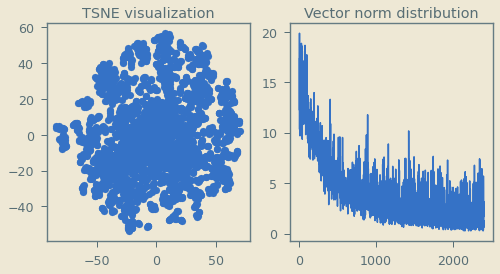

[('중증간장애', 0.969338595867157),
 ('신장애', 0.958929181098938),
 ('심기능장애', 0.9338376522064209),
 ('조혈장애', 0.9294331669807434),
 ('콩팥장애', 0.921029269695282)]

In [13]:
test = TSNE(2).fit_transform(caut_w2v.wv.vectors)

fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].set_title('TSNE visualization')
axs[0].scatter(test[:,0], test[:,1])

axs[1].set_title('Vector norm distribution')
axs[1].plot(np.linalg.norm(caut_w2v.wv.vectors, axis=1))
plt.show()

caut_w2v.wv.similar_by_word("간장애", topn=5)

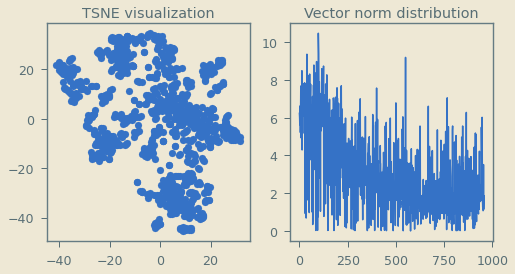

피리독신염산염


[('푸르설티아민염산염', 0.928024172782898),
 ('폴리사카리드철착염', 0.9197051525115967),
 ('니코틴산아미드', 0.9178380966186523),
 ('니코틴폴라크리렉스', 0.9173969030380249),
 ('니코틴', 0.9171004891395569)]

In [14]:
test = TSNE(2).fit_transform(ingre_w2v.wv.vectors)

fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].set_title('TSNE visualization')
axs[0].scatter(test[:,0], test[:,1])

axs[1].set_title('Vector norm distribution')
axs[1].plot(np.linalg.norm(ingre_w2v.wv.vectors, axis=1))
plt.show()

qw =  ingre_w2v.wv.index_to_key[0]
print(qw)
ingre_w2v.wv.similar_by_word(qw, topn=5)

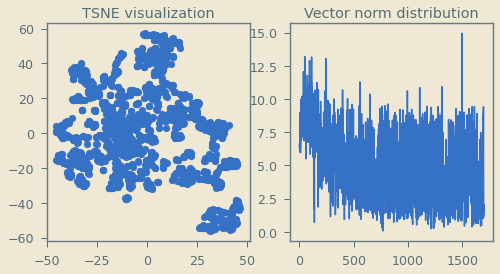

근육통


[('근육통 근육피로', 0.700785756111145),
 ('신경통', 0.6858784556388855),
 ('관절통', 0.6656404137611389),
 ('골관절통', 0.6379086971282959),
 ('요통', 0.614311933517456)]

In [15]:
test = TSNE(2).fit_transform(symptom_w2v.wv.vectors)

fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].set_title('TSNE visualization')
axs[0].scatter(test[:,0], test[:,1])

axs[1].set_title('Vector norm distribution')
axs[1].plot(np.linalg.norm(symptom_w2v.wv.vectors, axis=1))
plt.show()

qw =  symptom_w2v.wv.index_to_key[0]
print(qw)
symptom_w2v.wv.similar_by_word(qw, topn=5)

___

## Merge vector to build medicine vector

In [16]:
symptom_vector = np.full(shape=(prep_df.shape[0], symptom_w2v.wv.vector_size), fill_value=np.nan)

for idx, ls in tqdm(enumerate(prep_df.splitted_symptom.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(symptom_w2v.wv.vector_size,))
    
    for word in ls : 
        wv = symptom_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    vector /= wc
    symptom_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

In [17]:
ingredient_vector = np.full(shape=(prep_df.shape[0], ingre_w2v.wv.vector_size), fill_value=np.nan)

for idx, ls in tqdm(enumerate(prep_df.splitted_ingredient.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(ingre_w2v.wv.vector_size,))
    
    for word in ls : 
        wv = ingre_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    vector /= wc
    ingredient_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

In [18]:
caution_vector = np.full(shape=(prep_df.shape[0], caut_w2v.wv.vector_size), fill_value=0.)

for idx, ls in tqdm(enumerate(prep_df.tokenized_caution.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(caut_w2v.wv.vector_size,))
    
    for word in ls : 
        wv = caut_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    if wc == 0 :
        print("There was no word at {}th row!".format(idx))
    else : 
        vector /= wc
        caution_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

There was no word at 3th row!
There was no word at 18th row!
There was no word at 105th row!
There was no word at 124th row!
There was no word at 134th row!
There was no word at 135th row!
There was no word at 3094th row!
There was no word at 3270th row!


___

## Vector Stats check before concatenate

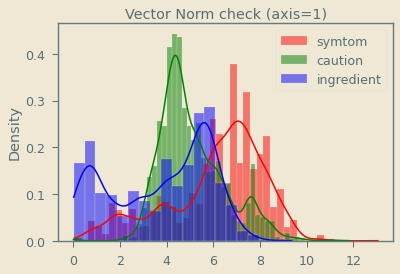

In [19]:
plt.title("Vector Norm check (axis=1)")
sns.histplot(np.linalg.norm(symptom_vector, axis=1), label='symptom', stat='density', color='red', alpha=0.5, kde=True)
sns.histplot(np.linalg.norm(caution_vector, axis=1), label='caution', stat='density', color='green', alpha=0.5, kde=True)
sns.histplot(np.linalg.norm(ingredient_vector, axis=1), label='ingredient', stat='density', color='blue', alpha=0.5, kde=True)

plt.legend()
plt.show()

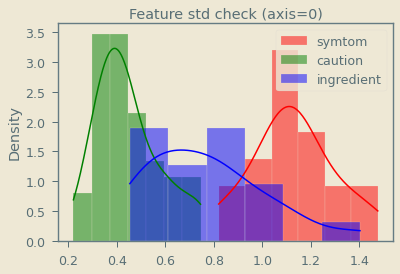

In [20]:
plt.title("Feature std check (axis=0)")
sns.histplot(np.std(symptom_vector, axis=0), label='symptom', stat='density', color='red', alpha=0.5, kde=True)
sns.histplot(np.std(caution_vector, axis=0), label='caution', stat='density', color='green', alpha=0.5, kde=True)
sns.histplot(np.std(ingredient_vector, axis=0), label='ingredient', stat='density', color='blue', alpha=0.5, kde=True)

plt.legend()
plt.show()

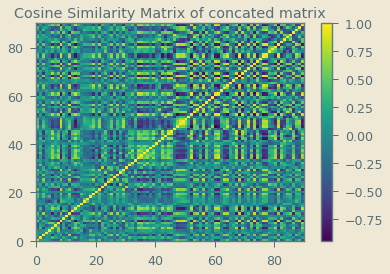

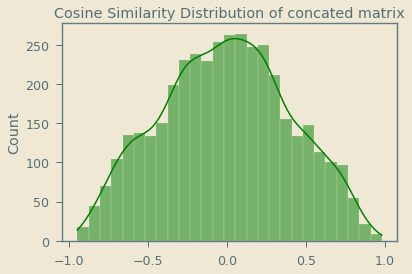

In [21]:
cossim_mat = cosine_similarity(np.hstack([normalize(symptom_vector), normalize(ingredient_vector), normalize(caution_vector)]).T)

plt.title("Cosine Similarity Matrix of concated matrix")
plt.pcolor(cossim_mat)
plt.colorbar()
plt.show()

plt.title("Cosine Similarity Distribution of concated matrix")
cossim_mat[np.tril_indices_from(cossim_mat)] = np.nan
sns.histplot(cossim_mat[np.isfinite(cossim_mat)], kde=True, color='green')
plt.show()

___

# Concat & Cluster

In [22]:
stacked_vector = np.hstack([normalize(symptom_vector), normalize(ingredient_vector), normalize(caution_vector)])

In [23]:
U, S, Vt = np.linalg.svd(stacked_vector-np.mean(stacked_vector, 0))

cumul_var_ratio = np.cumsum((S**2)/np.sum(S**2))
truncate_idx = np.where(cumul_var_ratio > 0.9)[0].min()

In [24]:
reduced_emb = np.dot(stacked_vector - np.mean(stacked_vector, 0), Vt[:truncate_idx].T)

In [25]:
ncl = 1000 # determined by silhouette score
label = AgglomerativeClustering(ncl).fit_predict(normalize(reduced_emb))

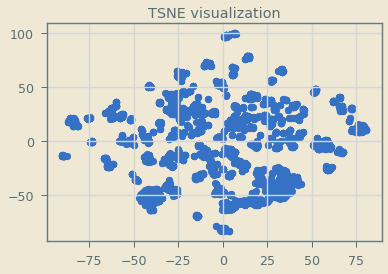

In [26]:
tsne_emb = TSNE(2).fit_transform(reduced_emb)

plt.title("TSNE visualization")
plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
plt.grid()
plt.show()

In [27]:
def calc_cossim_arr(x) : 
    cossim_arr = cosine_similarity(x)
    cossim_arr[np.tril_indices_from(cossim_arr)] = np.nan
    return np.nanmean(cossim_arr)

In [28]:
vis_cnt = 5
cnt = 0

for l in np.unique(label) :
    bool_ = label == l    
    allocated_df = prep_df.loc[bool_].iloc[:, [0,1,2,3,4]]
    
    if allocated_df.shape[0] == 1 : 
        continue
    
    display(allocated_df.head(3)) # only looks 3 of them
    display(Markdown("_________"))
    
    cnt += 1
    if cnt > vis_cnt : 
        break

,itemname,entpname,ingredient,symtom,caution
361,비오라민정,명인제약(주),"피리독살포스페이트수화물,직타용아스코르브산,푸르설티아민,토코페롤아세테이트2배산,히드록...","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 노년기의 비타민 E & B1 ...",이 약에 과민증 환자 만 3개월 미만의 영아는 이 약을 복용하지 마십시오 이 약을...
3550,에코파워600정,(유)한풍제약,"콘드로이틴설페이트나트륨,니코틴산아미드,시아노코발라민1000배산,피리독신염산염,콜레칼...","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 발육기, 노년기의 비타민 B1...",고칼슘혈증 유육종증 신장질환 이 약에 과민증 환자 만 12개월 미만의 젖먹이...
3823,메디콘600정,(주)바스칸바이오제약,"콘드로이틴설페이트나트륨,니코틴산아미드,시아노코발라민1000배산,피리독신염산염,콜린타...","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 노년기의 비타민 B1 & B2...",이 약에 과민증 환자 만 12개월 미만의 젖먹이 고칼슘혈증 혈액중에 칼슘이 과잉...


_________

,itemname,entpname,ingredient,symtom,caution
285,씨이멕스연질캡슐,동화약품(주),"비타민E,아스코르브산","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 노년기의 비타민 C & E의 ...",이 약 또는 대두유 콩 땅콩에 과민증 환자 만 3개월 미만의 젖먹이는 이 약을 ...
4176,티뮤즈연질캡슐,영풍제약(주),"비타민E,아스코르브산","육체피로, 임신,수유기, 병중,병후의 체력 저하 시, 노년기의 비타민 E & C의 ...",이 약 또는 대두유 콩 땅콩에 과민증 환자 만 3개월 미만의 젖먹이는 이 약을 ...


_________

,itemname,entpname,ingredient,symtom,caution
992,헤모렉스크림(프라목신염산염),대화제약(주),프라목신염산염,"치질로 인한 불쾌감, 작열감, 가려움의 일시적 완화",이 약에 과민증 환자는이 약을 사용하지 마십시오 이 약을 사용하기 전에 12세 이하...
1308,프라렉신크림(프라목신염산염),태극제약(주),프라목신염산염,"치질로 인한 불쾌감, 작열감, 가려움의 일시적 완화",이 약에 과민증 환자는이 약을 사용하지 마십시오 이 약을 사용하기 전에 12세 이하...
1570,프라맥스크림(프라목신염산염),에이치엘비제약(주),프라목신염산염,"치질로 인한 불쾌감, 작열감, 가려움의 일시적 완화",이 약에 과민증 환자는이 약을 사용하지 마십시오 이 약을 사용하기 전에 12세 이하...


_________

,itemname,entpname,ingredient,symtom,caution
188,삼천당산화마그네슘정250밀리그람,삼천당제약(주),산화마그네슘,"위.십이지장궤양, 위염, 위산과다의 제산작용 및 증상의 개선, 변비증",신장애 설사 환자는 이 약을 복용하지 마십시오 이 약을 복용하기 전에심기능 장애 ...
432,한국유나이티드산화마그네슘정250mg,한국유나이티드제약(주),산화마그네슘,"위.십이지장궤양, 위염, 위산과다의 제산작용 및 증상의 개선, 변비증",신장애 설사 환자는 이 약을 복용하지 마십시오 이 약을 복용하기 전에심기능 장애 ...
715,마그오캡슐250mg(산화마그네슘),(주)한국파마,산화마그네슘,"위.십이지장궤양, 위염, 위산과다의 제산작용 및 증상의 개선과변비증",심한 신기능장애 설사 환자 갈락토오스 불내성 유당분해효소 결핍증 또는 ...


_________

,itemname,entpname,ingredient,symtom,caution
376,알파아세트아미노펜정500밀리그람,알파제약(주),아세트아미노펜,"감기로 인한 발열 및 동통, 두통, 신경통, 근육통, 월경통, 염좌통과 치통, 관절...",이 약에 과민증 환자 소화성궤양 심한 혈액이상 심한 간장애 심한 신장장애 ...
402,세리콘정(아세트아미노펜),오스틴제약(주),아세트아미노펜,"감기로 인한 발열 및 동통, 두통, 신경통, 근육통, 월경통, 염좌통과 치통, 관절...",이 약에 과민증 환자 소화성궤양 심한 혈액이상 심한 간장애 심한 신장장애 ...
446,삼익아세트아미노펜정500밀리그람,삼익제약(주),아세트아미노펜,"감기로 인한 발열 및 동통, 두통, 신경통, 근육통, 월경통, 염좌통과 치통, 관절...",이 약에 과민증 환자 소화성궤양 심한 혈액이상 심한 간장애 심한 신장장애 ...


_________

,itemname,entpname,ingredient,symtom,caution
463,성광알파헥시딘5%액(글루콘산클로르헥시딘액),(주)퍼슨,글루콘산클로르헥시딘액,"손 및 피부의 소독, 의료용구의 소독, 가구, 기구 등의 소독, 피부의 창상부위 소독",이 약에 과민증 경험자 뇌 척수 귀 질 방광 구강 등의 점막면 눈에는 사용하...
1823,구미헥시크린에이액(글루콘산클로르헥시딘액),구미제약(주),글루콘산클로르헥시딘액,"손 및 피부의 소독, 의료용구의 소독, 가구, 기구 등의 소독, 피부의 창상부위 소독",이 약에 과민증 경험자 뇌 척수 귀 질 방광 구강 등의 점막면 눈에는 사용하...
1824,구미히비크린에이액(글루콘산클로르헥시딘액),구미제약(주),글루콘산클로르헥시딘액,"항균 피부 세정제로서, 일반 피부 및 상처부위 세정, 수술 시 손 소독, 개인의 손...",이 약에 과민증 경험자는 사용하지 마십시오 다른 약물에 과민증 환자 천식 등 알레르...


_________

In [29]:
mem = list()

for l in np.unique(label) :
    bool_ = label == l
    
    allocated_iv = ingredient_vector[bool_].copy()
    allocated_sv = symptom_vector[bool_].copy()
    allocated_cv = caution_vector[bool_].copy()
    
    if allocated_iv.shape[0] <= 1 : 
        continue

    ic, sc, cc = map(lambda x : np.round(calc_cossim_arr(x),3), [allocated_iv, allocated_sv, allocated_cv])
    mem.append((ic, sc, cc))

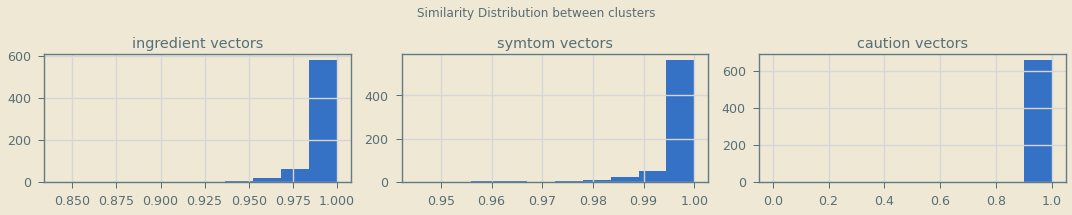

In [30]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
flattened_axs = axs.ravel()

fig.suptitle("Similarity Distribution between clusters")
for fn, idx in zip(['ingredient', 'symptom', 'caution'], range(len(mem[0]))) : 
    flattened_axs[idx].set_title("{} vectors".format(fn))
    flattened_axs[idx].hist(list(map(lambda x : x[idx], mem)), bins=10)
    flattened_axs[idx].grid()
fig.tight_layout()
fig.show()

# Note

- ingredient, symptom, caution 세 가지 feature 로 concatenate 한 medicine vector 는 각 feature 가 모두 정확히 일치하는 경우가 같은 클러스터로 배정받는 경우가 많다. 
    - 위의 histogram 을 보면, ingredient 의 경우 그 경향성이 제일 강하지만, 다른 feature 들도 매우 높은 편이다. 

- 이러한 결과가 데이터 특성에 따라 어쩔 수 없이 발생하는 것이라고 해도, 각 feature vector가 잘 학습되었는지 확인하기에는 역부족이다. 
    - feature embedding 을 하지 않고, one-hot-encoding 후 jaccard similarity 만 계산해도 위와 같은 결과는 만들 수 있기 때문이다.

- embedding vector 가 잘 학습되었는지 확인하는 실험으로 두 개를 제안한다.
    1. 특정 feature vector $v_{target_feature}$ ex) $v_{ingredient}$ 만을 사용하여 feature vector $v_{target_feature}$ 간 유사도가 높아질 수록 다른 두 feature vector $v_{remained_feature}$ 간의 유사도 또한 점진적으로 증가하는지를 확인한다. 해당 실험은, 각 feature 가 잘 embedding 되었는지 확인할 뿐만 아니라, 형성된 manifold 가 smooth 하게 연결되었는지도 확인할 수 있다.
    
    2. 특정 feature vector $v_{target_feature}$ ex) $v_{ingredient}$ 만으로 medicine vector 를 define 하고 같은 cluster 에 속한 medicine이 높은 유사도의 나머지 feature 를 가지고 있는지 확인하며, (similarity 'within' the cluster) cluster 밖의 random vector 간의 similarity 의 차이를 계산하면서 (similarity 'between' clusters) 해당 차이가 클 수록 medicine vector 가 유의하게 잘 clustered 되었다고 해석할 수 있다.

- 위의 두 실험은 특정 vector 가 얼마나 잘 훈련되었는지를 확인할 수 있는 척도로 사용될 수 있다.

___

# Test 1

In [31]:
iv = ingredient_vector.copy()
sv = symptom_vector.copy()
cv = caution_vector.copy()

cossim_iv = cosine_similarity(iv)
cossim_sv = cosine_similarity(sv)
cossim_cv = cosine_similarity(cv)

cossim_iv[np.tril_indices_from(cossim_iv)] = np.nan
cossim_sv[np.tril_indices_from(cossim_sv)] = np.nan
cossim_cv[np.tril_indices_from(cossim_cv)] = np.nan

cossim_iv_vec = cossim_iv[np.isfinite(cossim_iv)]
cossim_sv_vec = cossim_sv[np.isfinite(cossim_sv)]
cossim_cv_vec = cossim_cv[np.isfinite(cossim_cv)]

In [32]:
mem = list()

for _ in tqdm(range(100)) : 
    sampled_idx = np.random.choice(np.arange(cossim_iv_vec.shape[0]), 1000, replace=False)
    sampled_cossim_iv_vec, sampled_cossim_sv_vec, sampled_cossim_cv_vec = \
    cossim_iv_vec[sampled_idx], cossim_sv_vec[sampled_idx], cossim_cv_vec[sampled_idx]
    sampled_correl_mat = np.corrcoef([sampled_cossim_iv_vec, sampled_cossim_sv_vec, sampled_cossim_cv_vec])
    mem.append(sampled_correl_mat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
samples = np.stack(mem)
std_ = samples.std(0)/samples.shape[0]
mean_ = samples.mean(0)
z = 1.96

In [34]:
display(Markdown("### Lower confidence interval of correlation"))
display(pd.DataFrame(mean_-z*std_, index=['ingredient', 'symptom', 'caution'],
            columns=['ingredient', 'symptom', 'caution']))

display(Markdown("### Higher confidence interval of correlation"))
display(pd.DataFrame(mean_+z*std_, index=['ingredient', 'symptom', 'caution'],
            columns=['ingredient', 'symptom', 'caution']))

### Lower confidence interval of correlation

,ingredient,symtom,caution
ingredient,1.000000,0.235710,0.132771
symtom,0.235710,1.000000,0.220118
caution,0.132771,0.220118,1.000000


### Higher confidence interval of correlation

,ingredient,symtom,caution
ingredient,1.000000,0.237181,0.133991
symtom,0.237181,1.000000,0.221265
caution,0.133991,0.221265,1.000000


# Note

1 번 실험을 수행하기 위해, 같은 feature 내의 cosine similarity 를 계산하고, 해당 유사도 meaure 간 correlation 을 확인하였다. 기대하는 것은 해당 correlation이 통계적 유의성을 띄면서 양의 값을 가지는 것이다. 위의 표를 보면, 95%의 confidence interval 내에서 각 feature 들이 14.5% ~ 25.1% 정도의 양의 상관성을 띔을 확인할 수 있었다.

____

## Test 2

In [35]:
def stat_test(vec, iters=30) : 
    cossim_symptom = cosine_similarity(vec[bool_])
    cossim_symptom[np.tril_indices_from(cossim_symptom)] = np.nan
    null_sim = np.nanmean(cossim_symptom)
    
    alternative_sim = 0
    for i in range(iters) : 
        cossim_symptom = cosine_similarity(vec[not_index_])
        cossim_symptom[np.tril_indices_from(cossim_symptom)] = np.nan
        alternative_sim += np.nanmean(cossim_symptom)
        
    return null_sim, alternative_sim/iters

In [36]:
nm_ls, vec_ls = ['ingredient', 'symptom', 'caution'], [ingredient_vector, symptom_vector, caution_vector]
ncl = 500 # arbitrarily determined

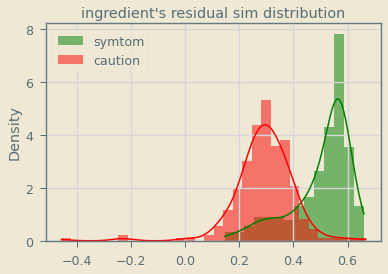

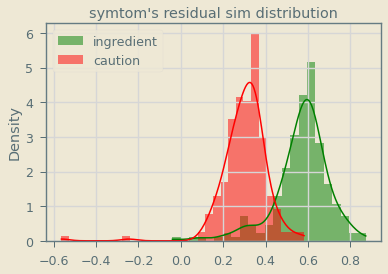

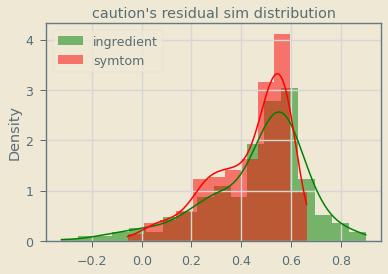

In [37]:
for idx in range(len(nm_ls)) : 
    
    stacked_vector = normalize(vec_ls[idx])
    U, S, Vt = np.linalg.svd(stacked_vector-np.mean(stacked_vector, 0))

    cumul_var_ratio = np.cumsum((S**2)/np.sum(S**2))
    truncate_idx = np.where(cumul_var_ratio > 0.9)[0].min()
    reduced_emb = np.dot(stacked_vector - np.mean(stacked_vector, 0), Vt[:truncate_idx].T)
    
    label = AgglomerativeClustering(ncl).fit_predict(normalize(reduced_emb))

    alt_ls1, alt_ls2 = list(), list()
    not_target_index = np.arange(len(nm_ls))[~np.in1d(np.arange(len(nm_ls)), idx)]
    
    for l in np.unique(label) :    
        bool_ = label == l
        if bool_.sum() < 5 : 
            continue
        not_index_ = np.random.choice(np.where(~bool_)[0], bool_.sum(), replace=False)

        null_alt1,alternative_alt1 = stat_test(vec_ls[not_target_index[0]])
        null_alt2,alternative_alt2 = stat_test(vec_ls[not_target_index[1]])

        diff1 = null_alt1 - alternative_alt1
        diff2 = null_alt2 - alternative_alt2

        alt_ls1.append(diff1)
        alt_ls2.append(diff2)

    sns.histplot(alt_ls1, color="green", label=nm_ls[not_target_index[0]], kde=True, stat="density", linewidth=0)
    sns.histplot(alt_ls2, color="red", label=nm_ls[not_target_index[1]], kde=True, stat="density", linewidth=0)
    
    plt.title("{}'s residual sim distribution".format(nm_ls[idx]))
    plt.grid()
    plt.legend()
    plt.show()

# Note

2번 실험의 위 히스토그램이 양의 값으로 치우칠 수록, 단 하나만의 feature 만을 사용하여 clustering 을 하여 이를 label 로 하는 값을 다른 feature 에 적용했을 때, 다른 곳에서도 클러스터를 형성하는 경향이 있음을 의미한다. 이 때, 전반적인 유사도 분포를 고려해주기 위해 diff 를 사용하였다. 해당 operation 은 각 feature 를 서로의 label 로 사용하여 embedding vector 의 건전성을 체크하는 것으로 해석할 수 있다.

1번 실험에서, 볼 수 있었던, ingredient 와 symptom 간 높은 correlation은 실험 2에서 가장 오른쪽에 치우쳐지는 경향성으로도 확인할 수 있으며, 반대의 경우 (low correlation between caution and ingredient) 도 동일하게 확인할 수 있다.

흥미로운 점은, clustering 을 하는 feature 의 주체가 무엇인지에 따라 결과값이 많이 달라진다는 것인데, caution 의 경우 ingredient 와 symptom 두 feature 에 대한 discriminative power 가 높았다. 이러한 결과값의 추정되는 이유로는 2가지가 있다.

- 첫 번째로는 모델 학습 방법 자체가 달랐다는 것이다. 다른 두 feature 와는 달리 caution 은 자연어(natural language)의 특정을 가지고 있고, 이에 따라 language modeling 으로 모델을 학습시켰다. 이에 따라 아래 두 가지 발생 가능한 문제 요인이 생기며, 이는 model의 결과 (embeddding)을 noisy 하게 만드는 데에 기여한다. 이 문제는 해당 project 가 가지는 한계로 추후 프로젝트로 미룬다.

    1. fasttext model 본래의 목적과는 다르게 사용 (with augmentation)
    2. 같은 약에 사용되는 ingredient/symptom 간에 공유하는 특성이 있을 것이라는 가정을 만들어내어 모델링

- 두 번째로는 데이터 상으로 복용 시 주의 사항이 일반의약품을 분류해내는 유의미한 factor 라는 것이다. 
    - 실제 데이터를 살펴봐도 (Concat & Cluster Section 참고) caution feature 가 다른 feature 를 잘 분류해냄을 확인할 수 있다.
    - 하지만, 가장 좋은 feature 인가에 대한 부분에서는 확실하지 않은 부분이 정성적, 정량적으로 존재한다.
        1. 복용 시 주의 사항이 의약품 분류의 가장 유의한 feature라는 부분이 석연치 않다.
        2. residual similarity distribution 의 분산이 가장 크다.